In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample_submit = pd.read_csv('input/sample_submit.csv')

In [3]:
train.head(10)

,customer_id,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,...,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,disbursed_date,Credit_level,employment_type,age,loan_default
0,105691,4,3,0,384989,666207,666207,0,0,0,...,81,0,1.00,2.50,1968,2019,1,0,51,0
1,24938,7,2,0,268670,387994,387994,0,0,0,...,161,0,1.00,1.33,1992,2019,9,0,27,0
2,104389,5,4,1,3519013,3613854,3576048,0,0,0,...,3576048,0,0.99,3.00,1991,2019,13,1,28,0
3,54688,43,13,6,1867106,2484678,2486856,0,0,0,...,0,0,1.00,1.42,1964,2019,3,1,55,0
4,63894,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1995,2019,-1,0,24,0
5,146589,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1978,2019,-1,1,41,0
6,8061,2,1,0,522457,2042000,2042000,0,0,0,...,2042000,0,1.00,1.50,2000,2019,11,2,19,0
7,42006,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1996,2019,-1,0,23,0
8,19210,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1975,2019,-1,1,44,0
9,14324,2,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1985,2019,13,0,34,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    150000 non-null  int64  
 1   main_account_loan_no           150000 non-null  int64  
 2   main_account_active_loan_no    150000 non-null  int64  
 3   main_account_overdue_no        150000 non-null  int64  
 4   main_account_outstanding_loan  150000 non-null  int64  
 5   main_account_sanction_loan     150000 non-null  int64  
 6   main_account_disbursed_loan    150000 non-null  int64  
 7   sub_account_loan_no            150000 non-null  int64  
 8   sub_account_active_loan_no     150000 non-null  int64  
 9   sub_account_overdue_no         150000 non-null  int64  
 10  sub_account_outstanding_loan   150000 non-null  int64  
 11  sub_account_sanction_loan      150000 non-null  int64  
 12  sub_account_disbursed_loan    

In [5]:
train['main_active_loan_ratio'] = train['main_account_active_loan_no']/train['main_account_loan_no']
train['main_active_loan_ratio'] = train['main_active_loan_ratio'].fillna(0)

train['active_overdue_loan_ratio'] = train['main_account_active_loan_no']/train['main_account_loan_no']
train['active_overdue_loan_ratio'] = train['main_active_loan_ratio'].fillna(0)

In [6]:
train['active_overdue_loan_ratio']

0         0.750000
1         0.285714
2         0.800000
3         0.302326
4         0.000000
            ...   
149995    0.000000
149996    0.000000
149997    0.190476
149998    0.000000
149999    0.000000
Name: active_overdue_loan_ratio, Length: 150000, dtype: float64

histogram

In [7]:
plt.style.use('seaborn')

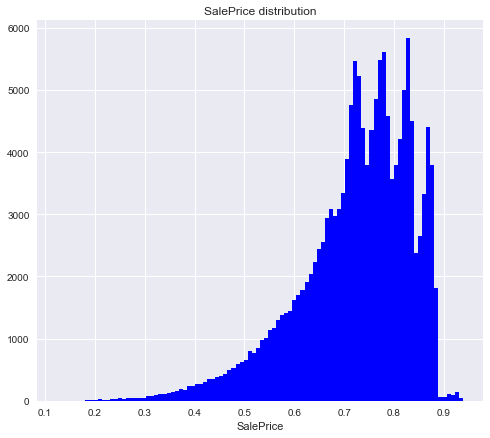

In [8]:
# sns.set_style("white")
# sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
plt.hist(train['loan_to_asset_ratio'],bins=100, color="b");
# ax.xaxis.grid(False)
ax.set(ylabel="")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
# sns.despine(trim=True, left=True)
plt.show()

In [9]:
# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [10]:
# Skew and kurt
print("Skewness: %f" % train['loan_to_asset_ratio'].skew())
print("Kurtosis: %f" % train['loan_to_asset_ratio'].kurt())

Skewness: -1.034338
Kurtosis: 1.190097


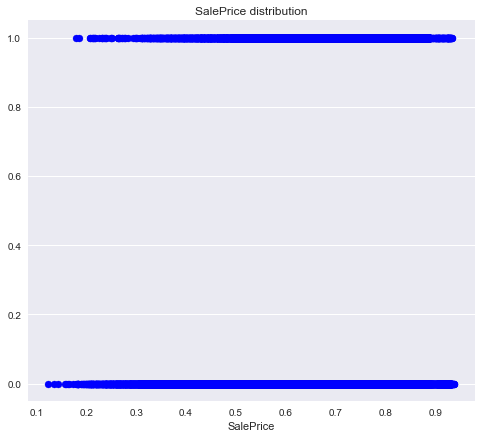

In [11]:
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
plt.scatter(train['loan_to_asset_ratio'],train['loan_default'],color="b");
ax.xaxis.grid(False)
ax.set(ylabel="")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
# sns.despine(trim=True, left=True)
plt.show()